# Predicting House Prices

## Objectives

Predict sales prices of residential homes in Ames, Iowa. Practice feature engineering with RFE and regression techiques like OLS and regularization (Lasso Regression). I am using the [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview) available on Kaggle. 

In [1]:
#Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

/Users/nataliablock/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/nataliablock/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


## Loading data

In [2]:
#Loading train dataset
train=pd.read_csv('train.csv')

In [3]:
# Checking the train dataset

print("\n Train dataset dimensions", train.shape)
print("\n Columns info", train.info())


 Train dataset dimensions (1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual   

This first look at the data shows that there are features with a lot of missing values. Comparing the data type in the dataset and the data description document we can see that a lot of the variables are classified wrongly in the dataset. Besides, categorical variables must be introduced to algorithms in a numeric value, not as labels. 

In [4]:
# Loading test dataset
test=pd.read_csv('test.csv')

In [5]:
# Checking test dataset
print('\n Test dataset dimensions', test.shape)
print("\n Columns info", test.info())


 Test dataset dimensions (1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    

## Data Wrangling

I'll concatenate both train and test datasets because I'll be doing a lot of data transformations and all the changes done in the training dataset should be incorporated to the test dataset. To be sure that I'll separate them in the exact same way they were made available I'll add an identifier so I can split the dataset before modeling.

In [6]:
#Adding identifier
train['identifier']='train'
test['identifier']='test'

In [7]:
#concatenating 
houses= pd.concat((train.loc[:,'MSSubClass':'identifier'], 
                      test.loc[:,'MSSubClass':'identifier']))
houses.shape

(2919, 81)

There are some categorial features that need to be transformed. Some appear as objects in the dataset; however there are cases in which a feature appears as numeric but it is actually categorical. Also, some of these categorical variables have NAs but they can be recoded as they contain important information. Finally, there are variables that have a LOT of categories. Some of them can be regrouped, others can't. Those that I believe that cannot be regrouped I'll leave as they are and see if it's worth using them during feature extraction.

So here are the steps for the data wrangling:

1. Recode features that are worth recoding;
2. Transforming the categorical features

<strong>Step 1: Recoding features</strong>

In [8]:
## Feature: Alley
print('Count by category:',houses['Alley'].value_counts())

print('\nCount of NAs:', houses['Alley'].isnull().sum())

Count by category: Grvl    120
Pave     78
Name: Alley, dtype: int64

Count of NAs: 2721


In [9]:
#NA indicates that the house has no alley access. It is the bigger
#'category', but the count is so big that the variable may have really 
#little variance. It probably won't be important for the model, but
#I'll recode anyway and decide whether it will be included in the model
#during feature extraction
houses['Alley']=houses['Alley'].fillna('no_alley')
print('Count by category:',houses['Alley'].value_counts())

Count by category: no_alley    2721
Grvl         120
Pave          78
Name: Alley, dtype: int64


In [10]:
##Features: OverallQual & OverallCond. I'll regroup these variables.

#Creating a dictionary with the recoding

overall_dic={'OverallQual':{10:'excelent', 9:'excelent',8:'good',
                           7:'good', 6:'above_average', 5:'average',
                           4:'poor', 3:'poor', 2:'poor', 1:'poor'},
            'OverallCond':{10:'excelent', 9:'excelent',8:'good',
                           7:'good', 6:'above_average', 5:'average',
                           4:'poor', 3:'poor', 2:'poor', 1:'poor'}}

#replacing
houses=houses.replace(overall_dic)

In [11]:
#Features: YearBuilt & YearRemodAdd. These variables go back to the
# nineteenth and twentieth ceturies. I'll create categories for each of
#them.

#function to create groups
def yearbuilt_group(year):
    if year <= 1900:
        return "1900_or_older"
    elif 1900 < year <= 1950:
        return "1901-1950"
    elif 1950 < year < 1970:
        return "1951 - 1969"
    elif 1970 <= year < 2000:
        return "1970 - 1999"
    elif 2000<= year:
        return "2000's"
    
    
#applying the function
houses['YearBuilt']=houses['YearBuilt'].apply(yearbuilt_group)

In [12]:
#YearRemodAdd

#function to code groups
def yearremod_group(year):
    if year < 1960:
        return "1950-1959"
    elif 1960 <= year < 1970:
        return "1760 - 1969"
    elif 1970 <= year < 1980:
        return "1970-1979"
    elif 1980 <= year < 1990:
        return "1980 - 1989"
    elif 1990 <= year < 2000:
        return "1990 - 1999"
    elif 2000<= year:
        return "2000's"
    
#applying function
houses['YearRemodAdd']=houses['YearRemodAdd'].apply(yearremod_group)

In [13]:
#Features: BsmtQual, BsmtCond, BsmtExposure & BsmtFinType1. NAs
#indicates that the house has no basement. I'll replace them to
# a 'no basement' category

for column in houses[['BsmtQual','BsmtCond', 'BsmtExposure',
                      'BsmtFinType1','BsmtFinType2']]:
    houses[column]=houses[column].fillna('no_basement')

In [14]:
#Functional - there's not a lot of variance in this feature. Most cases
#are categorized as "Typical". Minor and major deductions are in such
# a small number that it's worth just grouping them all in one category
#for deductions.

#creating the dictionary
deductions_dic={'Functional':{'Typ':'Typ', 'Min1':'deduc',
                             'Min2':'deduc', 'Mod':'deduc',
                             'Maj1':'deduc', 'Maj2':'deduc',
                             'Sev':'Sev'}}
#replacing
houses=houses.replace(deductions_dic)

In [15]:
## FireplaceQu: transforming NAs to category 'no_fireplace'

houses['FireplaceQu']=houses['FireplaceQu'].fillna('no_fireplace')

#Checking:
print('Count by category:',houses['FireplaceQu'].value_counts())

Count by category: no_fireplace    1420
Gd               744
TA               592
Fa                74
Po                46
Ex                43
Name: FireplaceQu, dtype: int64


In [16]:
#Creating a for loop to fill NAs on variables about garages. In these
#cases NA indicates that there's no garage in the house.

#Features:GarageType,GarageFinish,GarageQual,GarageCond

for column in houses[['GarageType','GarageFinish',
                      'GarageQual','GarageCond']]:
    houses[column]=houses[column].fillna('no_garage')

In [17]:
## Filling NAs for PoolQC, Fence, MiscFeature

houses['PoolQC']=houses['PoolQC'].fillna('no_pool')

houses['Fence']=houses['Fence'].fillna('no_fence')

houses['MiscFeature']=houses['MiscFeature'].fillna('no_miscellaneous')


In [18]:
## Checking the dataset to see if there are more changes to be done
houses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   object 
 17  OverallCond    2919 non-null   object 
 18  YearBuil

In [19]:
## Features that still have a lot of null cells: LotFrontage,
#MasVnrType, MasVnrArea, GarageYrBlt.  

#For LotFrontage I'll input the mean value of this variable
#I'll fill GarageYrBlt with the category '0'
#For MasVnrType and MasVnrArea we actually have NAs, meaning that
#we don't have any information about what the missing values 
#could be. I'll just leave the NAs as they are.

#LotFrontage:
mean_LotFrontage=houses['LotFrontage'].mean()

houses['LotFrontage']=houses['LotFrontage'].fillna(mean_LotFrontage)

# GarageYrBlt 
houses['GarageYrBlt']=houses['GarageYrBlt'].fillna(0)

In [20]:
#Features to be transformed as categoricals
cat=['MSSubClass','MSZoning','Street', 'Alley','LotShape','LandContour',
    'Utilities', 'LotConfig', 'LandSlope','Neighborhood','Condition1',
    'Condition2','BldgType','HouseStyle', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd','RoofStyle','Exterior1st','Exterior2nd',
    'MasVnrType','ExterQual','ExterCond','Foundation','BsmtQual',
    'BsmtCond','BsmtExposure','BsmtFinType2', 'Heating','HeatingQC',
    'CentralAir','Electrical', 'KitchenQual','FireplaceQu','GarageType',
    'GarageFinish','GarageQual','GarageCond','GarageYrBlt','PavedDrive',
    'MoSold','YrSold','SaleType','SaleCondition','RoofMatl','BsmtFinType1',
    'Functional', 'PoolQC','Fence','MiscFeature']

In [21]:
#Saving a list of numeric features
num=['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
    'BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
    'GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
    'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',
    'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
    'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','SalePrice']


<strong>Step 2: Transforming categorical features</strong>

In [22]:
# Iterate over the columns to change those that are categories
for column in houses[cat]:
    houses[column] = houses[column].astype("category")
     

## Exploratory Data Analysis (EDA)

<strong>Dependent variable</strong>

Verifying the distribution of the target variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e110d1780>,
      dtype=object)

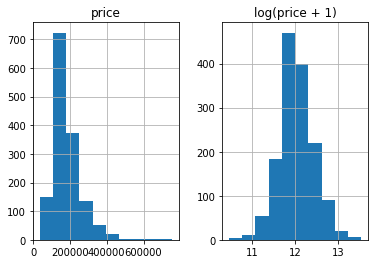

In [23]:
#Comparing price and log of price. 
new_price = {'price':houses["SalePrice"], 'log(price + 1)':np.log1p(houses['SalePrice'])}
prices= pd.DataFrame(new_price)
prices.hist()

In [24]:
#Summarizing price and log of price
prices.describe()

,price,log(price + 1)
count,1460.000000,1460.000000
mean,180921.195890,12.024057
std,79442.502883,0.399449
min,34900.000000,10.460271
25%,129975.000000,11.775105
50%,163000.000000,12.001512
75%,214000.000000,12.273736
max,755000.000000,13.534474


Price is not normally distributed so I'll have to use the log of price since regression makes the assumption that the data have a gaussian distribution.

In [25]:
#Transforming SalePrice to log of SalePrice
houses["SalePrice"] = np.log1p(houses["SalePrice"])

<strong>Independent Variables</strong>

Checking numeric variables for outliers</strong>

In [26]:
#Creating separate dataset just with numeric features
houses_num=houses[num]

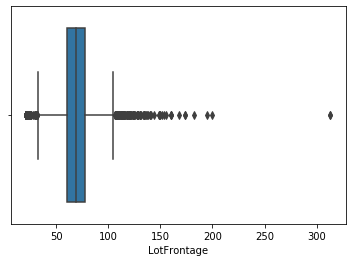

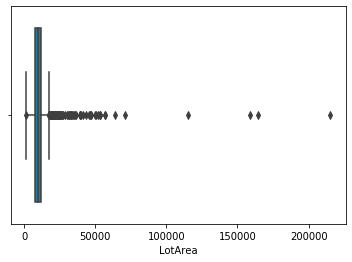

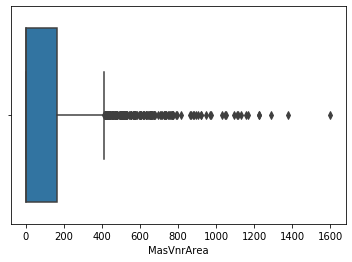

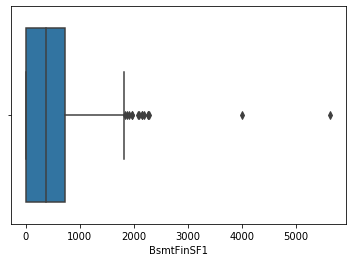

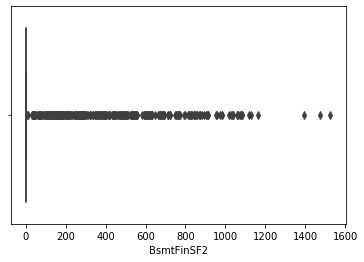

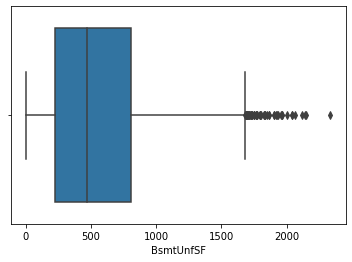

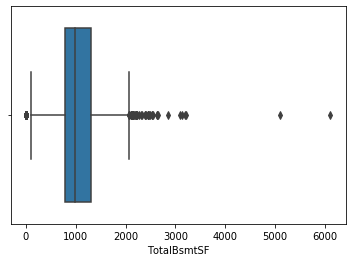

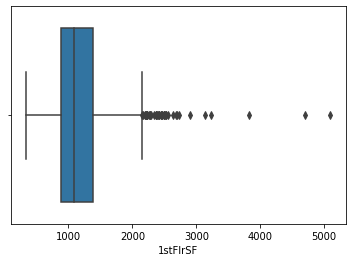

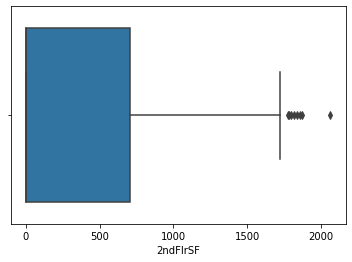

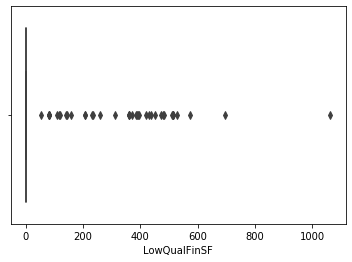

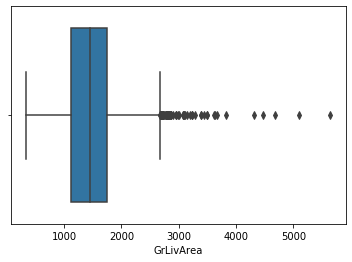

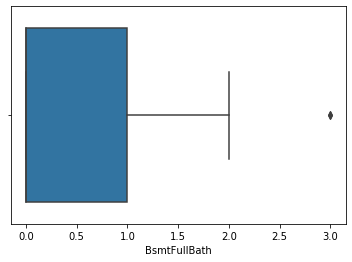

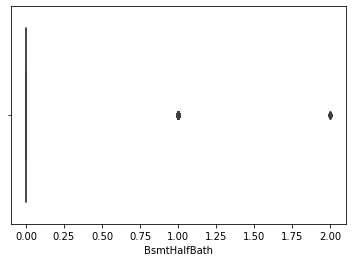

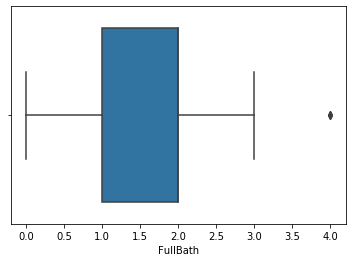

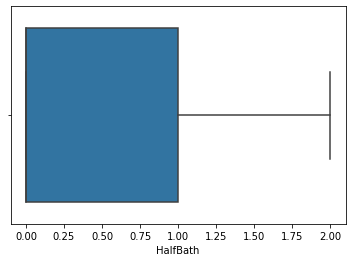

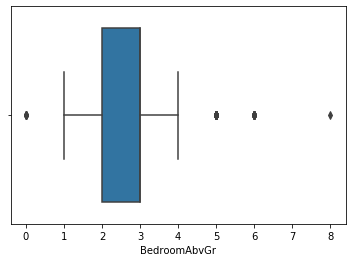

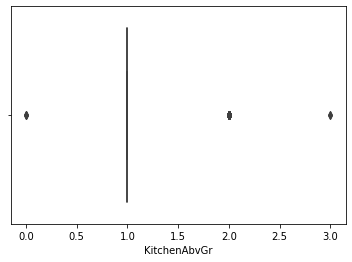

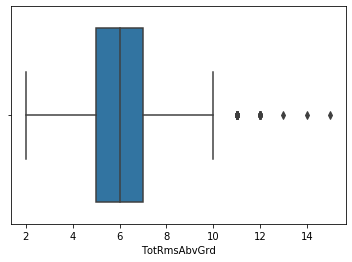

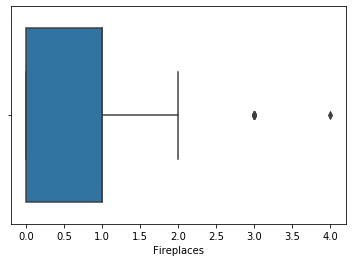

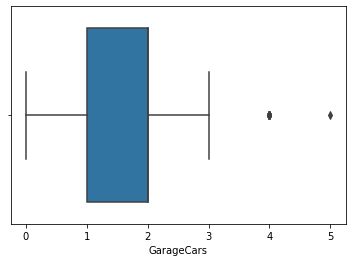

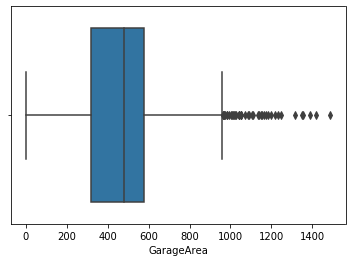

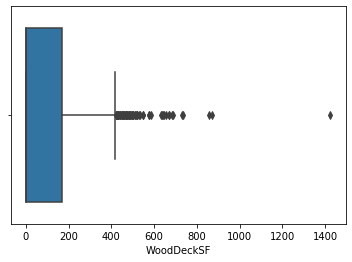

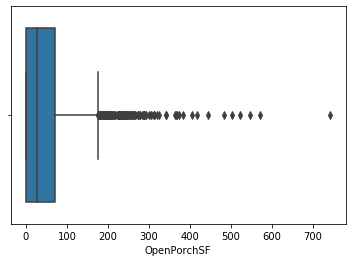

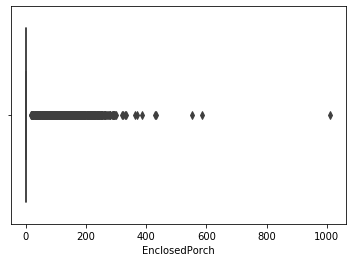

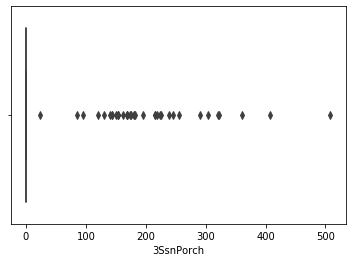

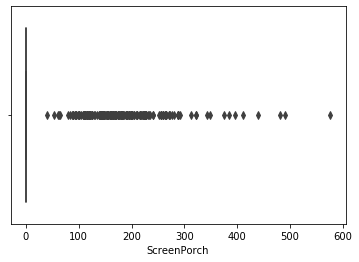

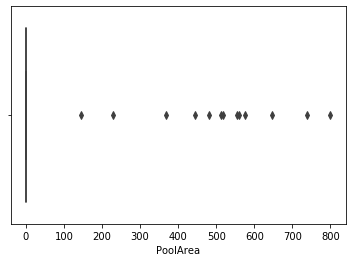

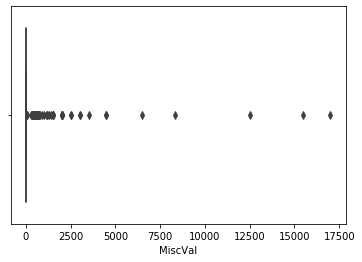

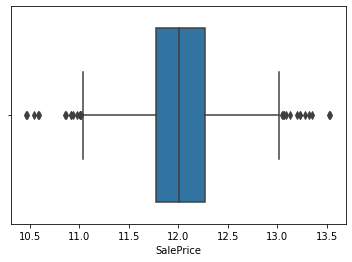

In [27]:
#For loop to create boxplots for all features so I can look for 
#outliers
for columns in houses_num:
    plt.figure()
    sns.boxplot(x=houses_num[columns])

I've looked every feature closely and noticed that there are some 
with a great number of zeros. In these cases we don't have a lot of
variation in the variables so I believe they'll probably be droppep 
during feature extraction. I'm taking off outliers from variables that
present variation in their distribution, which indicates that they may be
relevant for the model.

In [28]:
#Taking off outliers
houses= houses[houses['LotFrontage']<300]
houses= houses[houses['LotArea']<100000]
houses= houses[houses['BsmtUnfSF']<2336]
houses= houses[houses['TotalBsmtSF']<5000]
houses= houses[houses['1stFlrSF']<4000]
houses= houses[houses['GrLivArea']<4000]

## Feature Engineering and Selection

I'll standardize the numeric features, which means subtracting the mean of each observation and then dividing by the standard deviation so I can have all features in the same scale. For the categorical feartures I'll do one-hot encoding for variables which the categories are independent from each other and transform to ordinal those that have categories that are related.

In [29]:
#Scaling numeric features
scaler = StandardScaler() 
houses[num]= pd.DataFrame(scaler.fit_transform(houses[num]))

In [30]:
#Checking to see if there's any remaining NAN 
print("Is there any NAN?", houses.isnull().values.any())
print("How many?", houses.isnull().sum().sum())

Is there any NAN? True
How many? 72


In [31]:
#Dropping NAN
houses=houses.dropna()

In [32]:
#Separating ordinal and nominal categorical variables

cat_ordinal=['OverallQual','OverallCond','ExterQual','ExterCond',
            'BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2',
             'HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond','PoolQC']

cat_nominal=[i for i in cat if i not in cat_ordinal]

In [33]:
# define ordinal encoding
encoder_ord = OrdinalEncoder()
# transform data
houses[cat_ordinal]= pd.DataFrame(encoder_ord.fit_transform(houses[cat_ordinal]))

In [34]:
#One-hot encoding on nominal categorical features
houses= pd.get_dummies(houses,columns=cat_nominal)

In [35]:
#Spliting dataframe in train and test
train=houses[houses['identifier']=='train']
test=houses[houses['identifier']=='test']

In [36]:
#Dropping identifier from both dataframes
train.drop('identifier',axis='columns',inplace=True)
test.drop('identifier',axis='columns',inplace=True)

In [37]:
#Separating X and y
X_train=train.loc[:, train.columns != 'SalePrice']
y_train=train['SalePrice']

In [38]:
X_test=test.loc[:, test.columns != 'SalePrice']
y_test=test['SalePrice']

I have too many features. In order to decide which ones I'll use in the first model, that will be a multiple linear regression I'll do a feature selection with RFE (recursive feature selection) with cross validation(RFECV). Later I'll try running a Lasso Regression to see which features are used on this model and compare to those selected here with the RFECV.

In [39]:
#specifying model
lm=LinearRegression()

In [40]:
#defining the rfecv
rfecv=RFECV(estimator=lm, step=1, scoring='r2')

In [41]:
#fitting the rfecv to the training datasets
rfecv.fit(X_train,y_train)

RFECV(cv='warn',
      estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                 normalize=False),
      min_features_to_select=1, n_jobs=None, scoring='r2', step=1, verbose=0)

In [42]:
#How many features were selected?
rfecv.n_features_

24

In [43]:
# summarize all features. Here I'll search for the 24 variables 
#selected by the rfecv that are ranked as 1. These will be the features
#I'll use in the first model
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

Column: 0, Selected False, Rank: 335.000
Column: 1, Selected False, Rank: 341.000
Column: 2, Selected False, Rank: 360.000
Column: 3, Selected False, Rank: 357.000
Column: 4, Selected False, Rank: 359.000
Column: 5, Selected False, Rank: 344.000
Column: 6, Selected False, Rank: 338.000
Column: 7, Selected False, Rank: 355.000
Column: 8, Selected False, Rank: 356.000
Column: 9, Selected False, Rank: 362.000
Column: 10, Selected False, Rank: 217.000
Column: 11, Selected False, Rank: 345.000
Column: 12, Selected False, Rank: 262.000
Column: 13, Selected False, Rank: 261.000
Column: 14, Selected False, Rank: 192.000
Column: 15, Selected False, Rank: 350.000
Column: 16, Selected True, Rank: 1.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected True, Rank: 1.000
Column: 19, Selected True, Rank: 1.000
Column: 20, Selected False, Rank: 333.000
Column: 21, Selected False, Rank: 342.000
Column: 22, Selected False, Rank: 327.000
Column: 23, Selected False, Rank: 330.000
Column: 24, Se

In [44]:
#finding the index for SalePrice

train.columns.get_loc('SalePrice')

42

In [45]:
#list with selected features and the target variable

feat=[16,17,18,19,63,64,76,77,118,125,126,157,162,177,182,231,232,
     368,369,370,371,372,373,374,42]

In [46]:
#saving datasets only with the selected features

train_new=train.iloc[:, feat]
test_new=test.iloc[:, feat]

## Prediction

<strong> Model 1: Multiple Linear Regression </strong>

In [47]:
#Separating X and y
X_train_new=train_new.loc[:,train_new.columns != 'SalePrice']
y_train_new=train_new['SalePrice']

X_test_new=test_new.loc[:,test_new.columns != 'SalePrice']
y_test_new=test_new['SalePrice']

In [48]:
#Creating the model
linear_reg= LinearRegression(normalize= False, fit_intercept= True)

In [49]:
#Training the model
model1=linear_reg.fit(X_train_new, y_train_new)

In [50]:
# getting the importance of the variables (checking the coeficients)
importance_mod1 = model1.coef_

# summarize feature importance
for i,v in enumerate(importance_mod1):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.42816
Feature: 1, Score: 0.12058
Feature: 2, Score: -0.10160
Feature: 3, Score: 0.42657
Feature: 4, Score: -0.05093
Feature: 5, Score: 0.39149
Feature: 6, Score: -0.00557
Feature: 7, Score: -0.60823
Feature: 8, Score: -0.01325
Feature: 9, Score: 0.67559
Feature: 10, Score: 0.90176
Feature: 11, Score: -0.44437
Feature: 12, Score: -0.02342
Feature: 13, Score: -0.13612
Feature: 14, Score: -0.05658
Feature: 15, Score: -0.00000
Feature: 16, Score: -1.52322
Feature: 17, Score: 0.00000
Feature: 18, Score: -0.51675
Feature: 19, Score: -1.56197
Feature: 20, Score: 0.39158
Feature: 21, Score: -2.06407
Feature: 22, Score: -0.53674
Feature: 23, Score: -0.62770


In [51]:
#Taking off features that presented score=0
#saving datasets only with the selected features
feat_drop=[15,17]
train_new.drop(train_new.iloc[:,feat_drop], axis = 1, inplace=True)
test_new.drop(test_new.iloc[:,feat_drop], axis = 1, inplace=True)

In [52]:
#Separating X and y again
X_train_new=train_new.loc[:,train_new.columns != 'SalePrice']
y_train_new=train_new['SalePrice']

X_test_new=test_new.loc[:,test_new.columns != 'SalePrice']
y_test_new=test_new['SalePrice']

In [53]:
#Training the model again
model1=linear_reg.fit(X_train_new, y_train_new)

In [54]:
#feature names
features_mod1=X_train_new.columns

In [55]:
#R-Square
r2_score(y_test_new, model1.predict(X_test_new))

0.591366333627563

In [56]:
#OLS Coeficients
coef_mod1=pd.DataFrame(model1.coef_, index = X_train_new.columns,
                       columns=['mod1_coefficients'])
coef_mod1.head()

,mod1_coefficients
1stFlrSF,1.814253e+13
2ndFlrSF,2.059081e+13
LowQualFinSF,2.245252e+12
GrLivArea,-2.349559e+13
MSZoning_RM,-5.045026e-02


<strong> Model 2: Lasso Regression </strong>

In [57]:
# Creating LASSO model with the complete datasets
model2 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)

In [58]:
#R2 of lasso model
r2_score(y_test, model2.predict(X_test))

0.8137327476629372

In [59]:
#Lasso model coeficients
coef_mod2 = pd.DataFrame(model2.coef_, index = X_train.columns, 
                         columns=['mod2_coefficients'])
coef_mod2.head()

,mod2_coefficients
LotFrontage,0.047236
LotArea,0.024836
OverallQual,-0.004249
OverallCond,-0.008934
MasVnrArea,0.013569


In [60]:
#feature names
features=X_train.columns

In [61]:
#saving array with the absolute number of the coeficients
importance_mod2=np.abs(model2.coef_)

In [62]:
#features that survived Lasso regression:
lasso_feat=np.array(features)[importance_mod2!=0]

In [63]:
#How many features survived the lasso regression?
len(lasso_feat)

154

The problem with this model is that it still has too many variables, which can make generalization difficult. I may also have some overfitting in this model because the R2 is pretty high. 

The RFE determined that only 24 features would be enough. Let's see which were the 24 most important features in this model:

In [64]:
# What are the 24 most important coeficients? Saving as dataframe
top_24=pd.DataFrame(np.abs(coef_mod2['mod2_coefficients'].sort_values(ascending = False)).head(24))

<strong> Model 3: Multiple Linear Regression with features selected from Lasso Regression </strong>

In [65]:
#Creating list with the features I'll use in this model
feat_mod3=list(top_24.index)

In [66]:
#Separating X and y
X_train_mod3=train[feat_mod3]
y_train_mod3=train['SalePrice']

X_test_mod3=test[feat_mod3]
y_test_mod3=test['SalePrice']

In [67]:
#Training model 3
model3=linear_reg.fit(X_train_mod3, y_train_mod3)

In [68]:
#R-Square of model 3
r2_score(y_test_mod3, model3.predict(X_test_mod3))

0.7862075499436052

In [69]:
# Colecting x e y 
X_stats = houses[feat_mod3]
#y = houses['SalePrice'].values

In [70]:
#with statsmodels a constant needs to be created and included in
#the model
Xc_stats = sm.add_constant(X_train_mod3)
model_stats= sm.OLS(y_train_mod3, Xc_stats)
model_check = model_stats.fit()

In [71]:
model_check.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     226.1
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:48:57   Log-Likelihood:                -891.63
No. Observations:                1423   AIC:                             1833.
Df Residuals:                    1398   BIC:                             1965.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0694      0.056     -1.237      0.216      -0.179       0.041
GrLivArea                0.2957      0.028     10.675      0.000       0.241       0.350
TotalBsmtSF              0.2782      0.017     16.664      0.000       0.245       0.311
FullBath                 0.1819      0.017     10.608      0.000       0.148       0.216
GarageCars               0.1895      0.028      6.698      0.000       0.134       0.245
GarageYrBlt_1972.0       0.2195      0.128      1.717      0.086      -0.031       0.470
GarageYrBlt_1939.0       0.1664      0.156      1.067      0.286      -0.139       0.472
GarageYrBlt_1934.0       0.7298      0.326      2.237      0.025       0.090       1.370
LandContour_Bnk          0.0586      0.064      0.916      0.360      -0.067       0.184
Exterior2nd_Stucco       0.2048      0.095      2.152      0.032       0.018       0.392
HalfBath                 0.1264      0.015      8.709      0.000       0.098       0.155
GarageType_BuiltIn       0.0938      0.053      1.779      0.075      -0.010       0.197
GarageYrBlt_1958.0       0.1404      0.109      1.284      0.199      -0.074       0.355
GarageYrBlt_1979.0       0.1490      0.124      1.199      0.231      -0.095       0.393
Neighborhood_BrDale      0.1602      0.120      1.340      0.181      -0.074       0.395
MSZoning_FV              0.1240      0.061      2.035      0.042       0.004       0.243
TotRmsAbvGrd            -0.0536      0.022     -2.452      0.014      -0.097      -0.011
Fence_GdPrv              0.1004      0.062      1.625      0.104      -0.021       0.222
BsmtFullBath             0.0551      0.017      3.316      0.001       0.022       0.088
BsmtFinSF1               0.0948      0.018      5.293      0.000       0.060       0.130
YearBuilt_1901-1950     -0.0461      0.032     -1.440      0.150      -0.109       0.017
GarageArea               0.0909      0.027      3.318      0.001       0.037       0.145
Fireplaces               0.1028      0.014      7.186      0.000       0.075       0.131
LandSlope_Gtl            0.0392      0.057      0.691      0.490      -0.072       0.151
Neighborhood_NridgHt     0.1277      0.056      2.283      0.023       0.018       0.237
==============================================================================
Omnibus:                      282.807   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              743.284
Skew:                          -1.045   Prob(JB):                    3.96e-162
Kurtosis:                       5.858   Cond. No.                         53.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
#Creating a list of variables that were not significant to take off from
#from the model

feat_off=['GarageYrBlt_1939.0', 'LandContour_Bnk','GarageType_BuiltIn',
         'GarageYrBlt_1958.0', 'GarageYrBlt_1979.0', 'Neighborhood_BrDale',
         'YearBuilt_1901-1950','LandSlope_Gtl', 'Neighborhood_NridgHt']

<strong> Model 4: Multiple Linear Regression taking off features that were not statistically significant </strong>

In [73]:
#New list of features for model 4. I'll use the list of features
#for model 3 and take off the ones in the feat_off list
feat_mod4=[i for i in feat_mod3 if i not in feat_off]

#how many features will I have in the new model?
len(feat_mod4)

15

In [74]:
#Separating X and y for model 4
X_train_mod4=train[feat_mod4]
y_train_mod4=train['SalePrice']

X_test_mod4=test[feat_mod4]
y_test_mod4=test['SalePrice']

In [75]:
#Training model 4
model4=linear_reg.fit(X_train_mod4, y_train_mod4)

In [76]:
#R-Square of model 4
r2_score(y_test_mod4, model4.predict(X_test_mod4))

0.7880119772376738

I even got a slight improvement after taking the irrelevant variables! 

## Interpreting results

Now that I've done the predictions I'll run an OLS model with the dataset houses (that contains both training and test datasets) with the features used on model 4 in order to interpret the relationship between the sale price and these features. In other words, I want to understand what drives the prices of the houses in Ames.

In order to do that I'll use the statsmodels package because it gives a better summary of the regression outcome.

In [77]:
# Colecting x e y 
X = houses[feat_mod4]
y = houses['SalePrice'].values

In [78]:
#creating the constant
Xc = sm.add_constant(X)

#model for interpretation
model_interpret= sm.OLS(y, Xc)
model5 = model_interpret.fit()

In [79]:
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     710.8
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:48:58   Log-Likelihood:                -1806.3
No. Observations:                2838   AIC:                             3645.
Df Residuals:                    2822   BIC:                             3740.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0142      0.009     -1.550      0.121      -0.032       0.004
GrLivArea              0.2958      0.020     15.131      0.000       0.257       0.334
TotalBsmtSF            0.2756      0.012     23.287      0.000       0.252       0.299
FullBath               0.1853      0.012     15.344      0.000       0.162       0.209
GarageCars             0.1889      0.020      9.391      0.000       0.149       0.228
GarageYrBlt_1972.0     0.2313      0.091      2.553      0.011       0.054       0.409
GarageYrBlt_1934.0     0.1913      0.230      0.833      0.405      -0.259       0.642
Exterior2nd_Stucco     0.1377      0.068      2.015      0.044       0.004       0.272
HalfBath               0.1281      0.010     12.466      0.000       0.108       0.148
MSZoning_FV            0.0641      0.041      1.556      0.120      -0.017       0.145
TotRmsAbvGrd          -0.0568      0.015     -3.678      0.000      -0.087      -0.027
Fence_GdPrv            0.0298      0.044      0.683      0.495      -0.056       0.115
BsmtFullBath           0.0551      0.012      4.688      0.000       0.032       0.078
BsmtFinSF1             0.0948      0.013      7.452      0.000       0.070       0.120
GarageArea             0.0901      0.020      4.618      0.000       0.052       0.128
Fireplaces             0.1102      0.010     10.947      0.000       0.090       0.130
==============================================================================
Omnibus:                      586.775   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1604.676
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       5.970   Cond. No.                         52.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After taking some of the variables on model 4 other 3 features became irrelevant to the model. I'll take them out to check if I get any changes on other variables again. It may worth taking them out to get a even more concise model.

In [80]:
#Second list of variables to take off:

feat_off2= ['GarageYrBlt_1934.0', 'MSZoning_FV', 'Fence_GdPrv']

In [81]:
#List of features for model 6
feat_mod6=[i for i in feat_mod4 if i not in feat_off2]

In [82]:
# Running model 6

# Colecting x again, y is the same 
X= houses[feat_mod6]

#creating constant with new values of X
Xc= sm.add_constant(X)

#running model 6
model6_interpret= sm.OLS(y, Xc)
model6 = model6_interpret.fit()

#checking summary
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     888.1
Date:                Thu, 05 Aug 2021   Prob (F-statistic):               0.00
Time:                        10:48:58   Log-Likelihood:                -1808.1
No. Observations:                2838   AIC:                             3642.
Df Residuals:                    2825   BIC:                             3720.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0097      0.009     -1.107      0.268      -0.027       0.007
GrLivArea              0.2958      0.020     15.129      0.000       0.257       0.334
TotalBsmtSF            0.2757      0.012     23.306      0.000       0.252       0.299
FullBath               0.1857      0.012     15.390      0.000       0.162       0.209
GarageCars             0.1879      0.020      9.346      0.000       0.148       0.227
GarageYrBlt_1972.0     0.2302      0.091      2.544      0.011       0.053       0.408
Exterior2nd_Stucco     0.1357      0.068      1.987      0.047       0.002       0.270
HalfBath               0.1283      0.010     12.493      0.000       0.108       0.148
TotRmsAbvGrd          -0.0571      0.015     -3.696      0.000      -0.087      -0.027
BsmtFullBath           0.0542      0.012      4.612      0.000       0.031       0.077
BsmtFinSF1             0.0948      0.013      7.463      0.000       0.070       0.120
GarageArea             0.0909      0.020      4.663      0.000       0.053       0.129
Fireplaces             0.1101      0.010     10.935      0.000       0.090       0.130
==============================================================================
Omnibus:                      584.331   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1592.231
Skew:                          -1.086   Prob(JB):                         0.00
Kurtosis:                       5.957   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<strong> Next steps </strong>

1. Make final model with predictions
1. Unstandardize coefficients for interpretation
2. Calculate coefficients exponential 